In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [4]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('felixstowe_rotterdam.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [5]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
0,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.31,1.2,264.0,297.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
1,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.31,2.3,285.0,293.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
2,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,4.6,280.0,262.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
3,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,3.7,251.0,218.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
4,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,3.8,210.0,180.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001


In [6]:
ais_nan = ais

In [7]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [8]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [9]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [10]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [11]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [12]:
# Set invalid lengths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [13]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [14]:
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [15]:
ais_dropped.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Callsign
0,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:47:00,196.0,26.0,6.68,51.95,1.31,1.2,264.0,297.0,RTM-FXT-RTM,OVPB2
1,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:48:00,196.0,26.0,6.68,51.95,1.31,2.3,285.0,293.0,RTM-FXT-RTM,OVPB2
2,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:49:00,196.0,26.0,6.68,51.95,1.30,4.6,280.0,262.0,RTM-FXT-RTM,OVPB2
3,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:50:00,196.0,26.0,6.68,51.95,1.30,3.7,251.0,218.0,RTM-FXT-RTM,OVPB2
4,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:51:00,196.0,26.0,6.68,51.95,1.30,3.8,210.0,180.0,RTM-FXT-RTM,OVPB2


Text(0.5,1,u'All Positions Before Filtering')

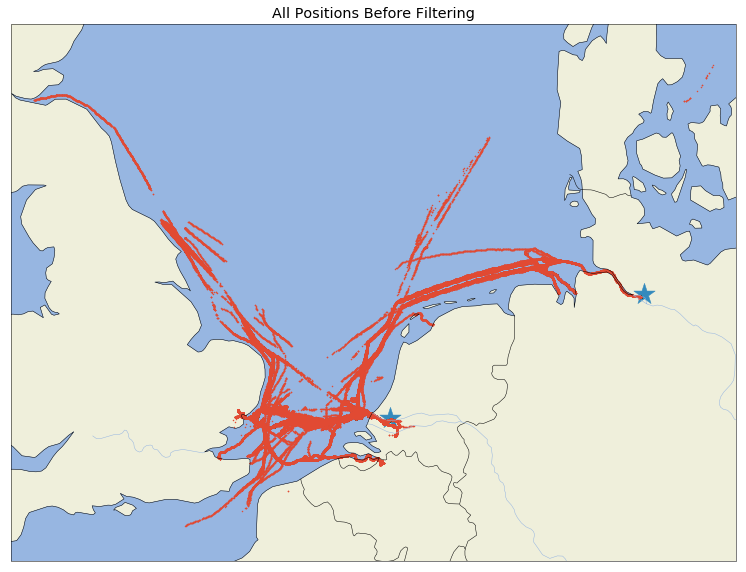

In [16]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

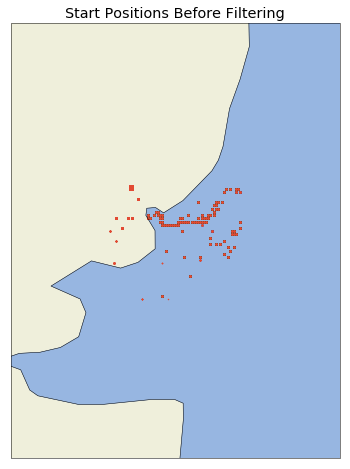

In [17]:
# Plot start positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

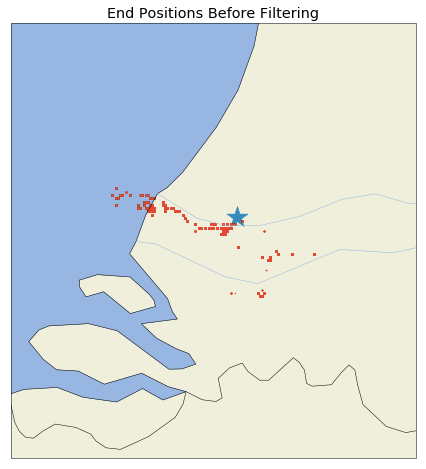

In [18]:
# Plot end positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [19]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 0.97) | (ais_dropped['Longitude'] > 4.8)
outside_lat_mask = (ais_dropped['Latitude'] < 51.62) | (ais_dropped['Latitude'] > 52.3)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

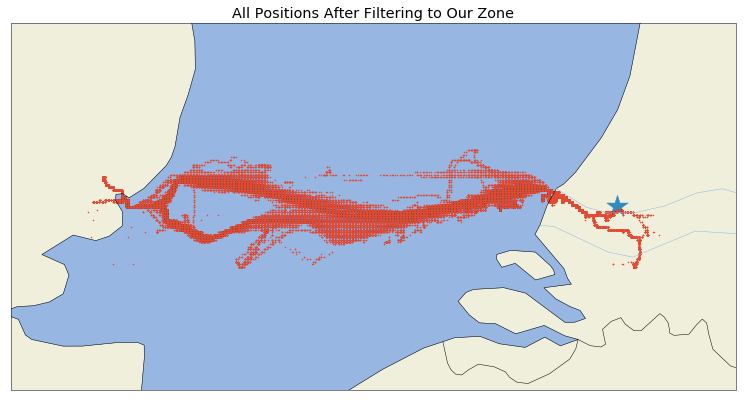

In [20]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

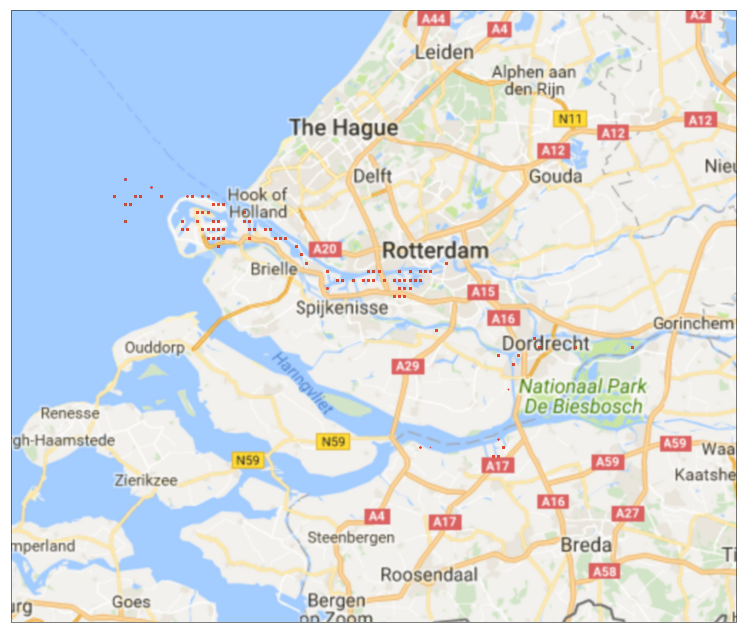

In [21]:
minlat = ais_zoned['EndLatitude'].min() - 0.2
maxlat = ais_zoned['EndLatitude'].max() + 0.2
minlong = ais_zoned['EndLongitude'].min() - 0.2
maxlong = ais_zoned['EndLongitude'].max() + 0.2

aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [22]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 3.94].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

/home/vhanke/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


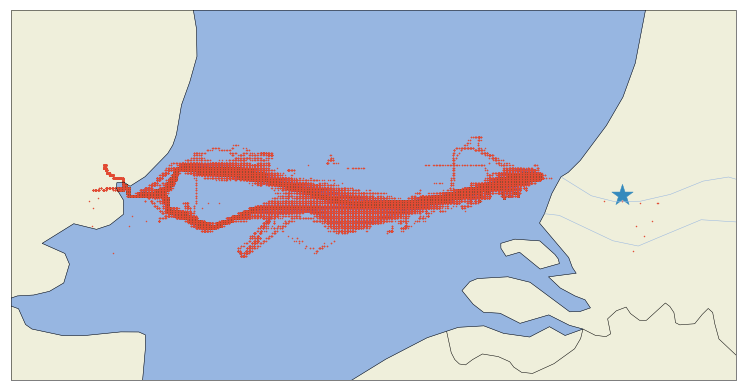

In [23]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [24]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

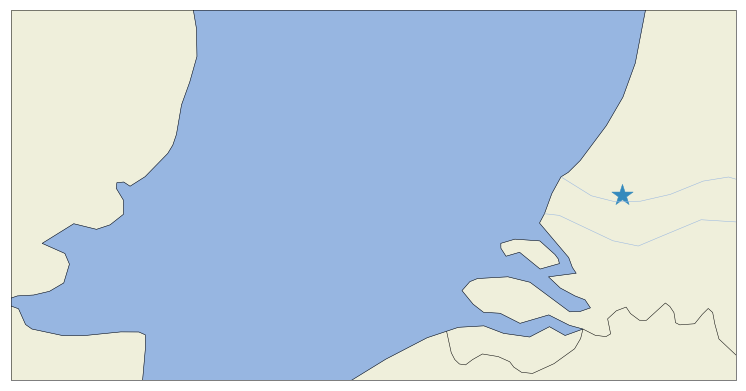

In [26]:
aismap.plot_trips(ais_tts, 'TravelTime')

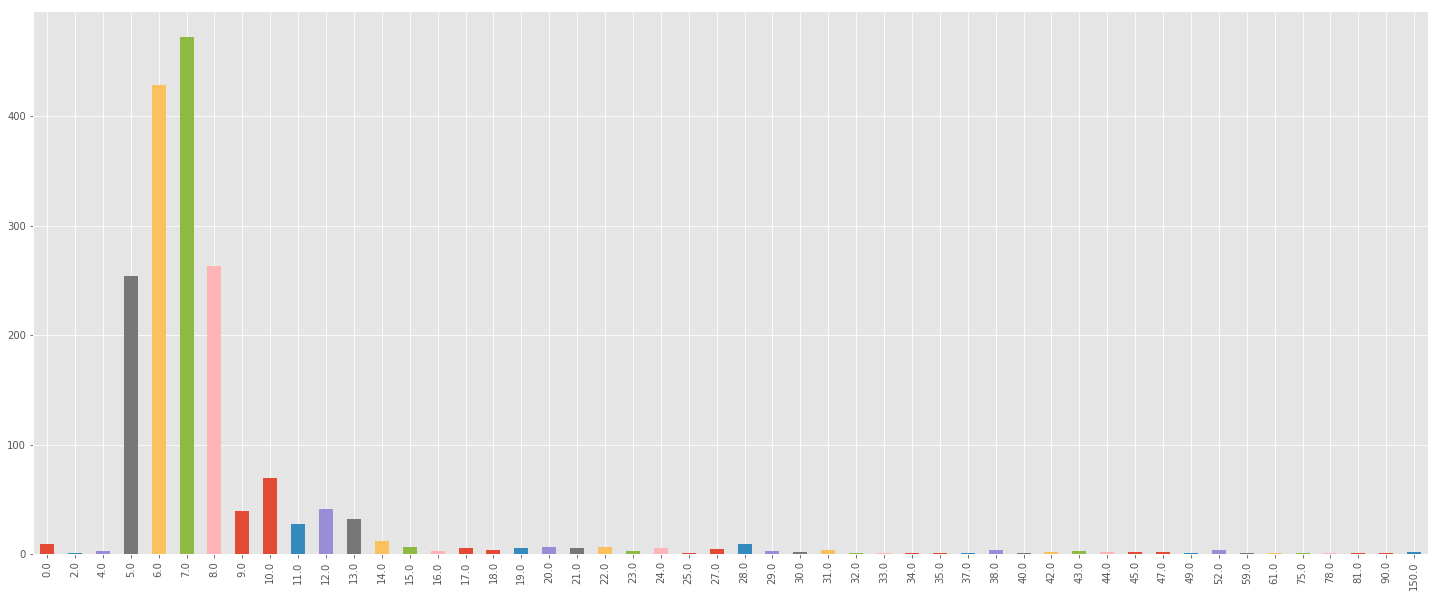

In [27]:
travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

In [62]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[(ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.90)) & (ais_tts['TravelTimeMins'] > 270)]

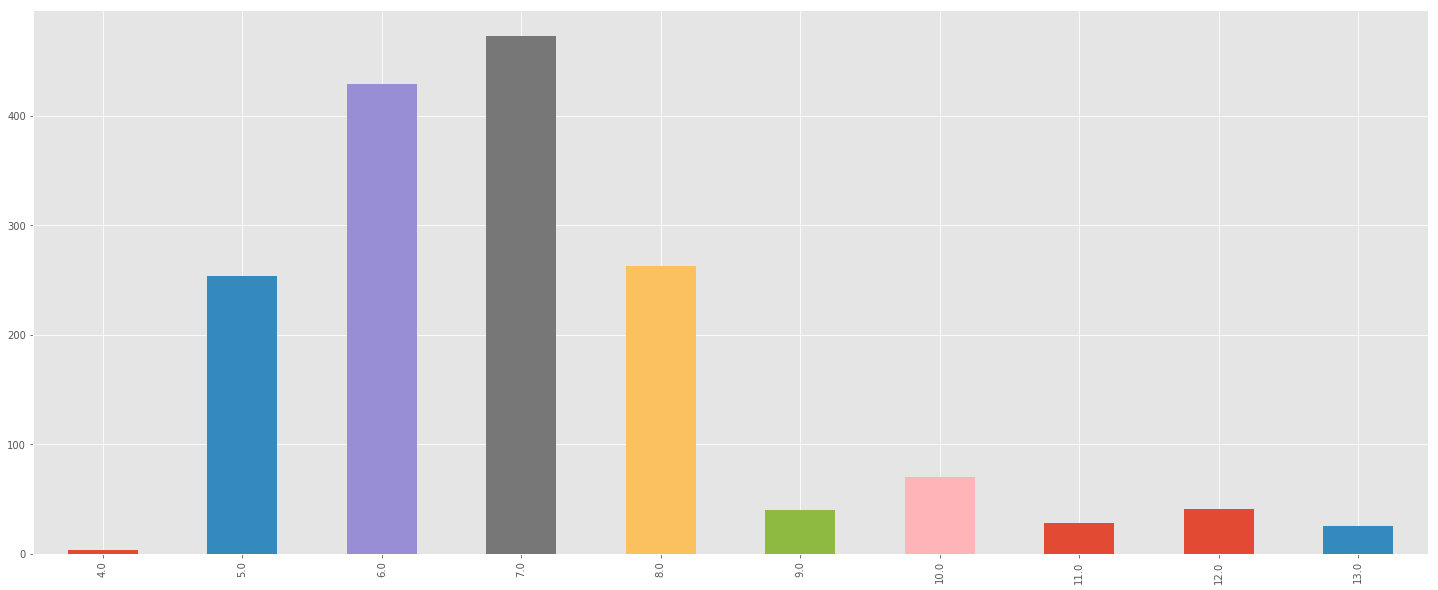

In [63]:
travel_times2 = ais_shortmaj.groupby('TripID')['TravelTime'].max()
travel_times2 = travel_times2.transform(lambda x : x.total_seconds() // 3600)
#ais_shortmaj.shape
travel_times2.value_counts().sort_index().plot.bar(figsize = (25, 10))

In [ ]:
#ais_shortmaj['Cur_Pos'] = list(zip(ais_shortmaj['Latitude'], ais_shortmaj['Longitude']))
#ais_shortmaj['End_Pos'] = list(zip(ais_shortmaj['EndLatitude'], ais_shortmaj['EndLongitude']))

In [ ]:
#ais_shortmaj['Distance'] =  ais_shortmaj.apply(lambda r: pandasVincenty(r), axis=1)
#ais_shortmaj.head()

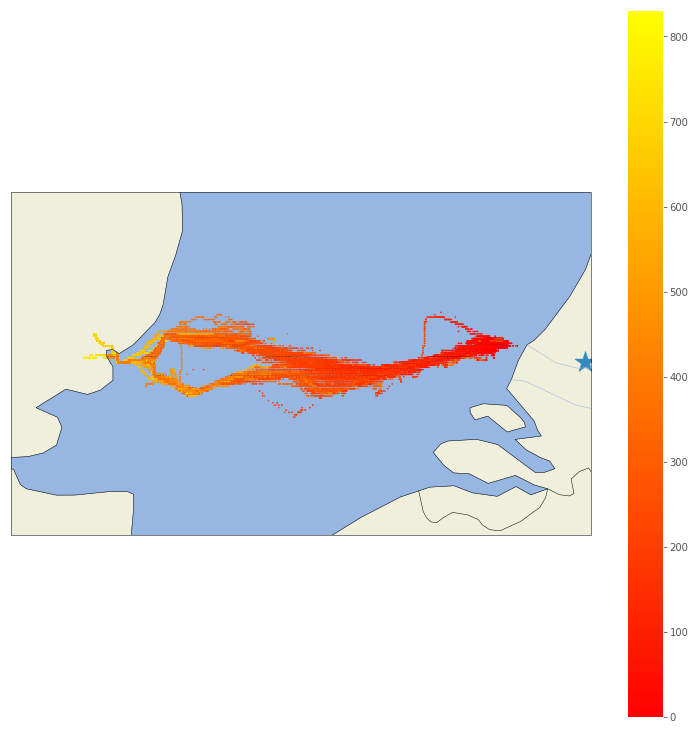

In [64]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [65]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
169149,439330,51.94,1.31,2016-07-24 15:11:00,51.97,4.03,2016-07-25 05:02:00,2016-07-24 15:15:00,363.0,46.0,...,1.31,0.8,233.4,347.0,ROTTERDAM,2CBJ6,13:51:00,831.0,13:47:00,827.0
169150,439330,51.94,1.31,2016-07-24 15:11:00,51.97,4.03,2016-07-25 05:02:00,2016-07-24 15:17:00,363.0,46.0,...,1.31,0.6,133.9,359.0,ROTTERDAM,2CBJ6,13:51:00,831.0,13:45:00,825.0
169151,439330,51.94,1.31,2016-07-24 15:11:00,51.97,4.03,2016-07-25 05:02:00,2016-07-24 15:19:00,363.0,46.0,...,1.31,1.3,221.1,13.0,ROTTERDAM,2CBJ6,13:51:00,831.0,13:43:00,823.0
169152,439330,51.94,1.31,2016-07-24 15:11:00,51.97,4.03,2016-07-25 05:02:00,2016-07-24 15:20:00,363.0,46.0,...,1.31,1.4,236.9,24.0,ROTTERDAM,2CBJ6,13:51:00,831.0,13:42:00,822.0
169153,439330,51.94,1.31,2016-07-24 15:11:00,51.97,4.03,2016-07-25 05:02:00,2016-07-24 15:21:00,363.0,46.0,...,1.31,1.7,252.1,37.0,ROTTERDAM,2CBJ6,13:51:00,831.0,13:41:00,821.0


Text(0.5,1,u'Longest Trip in the Data Set')

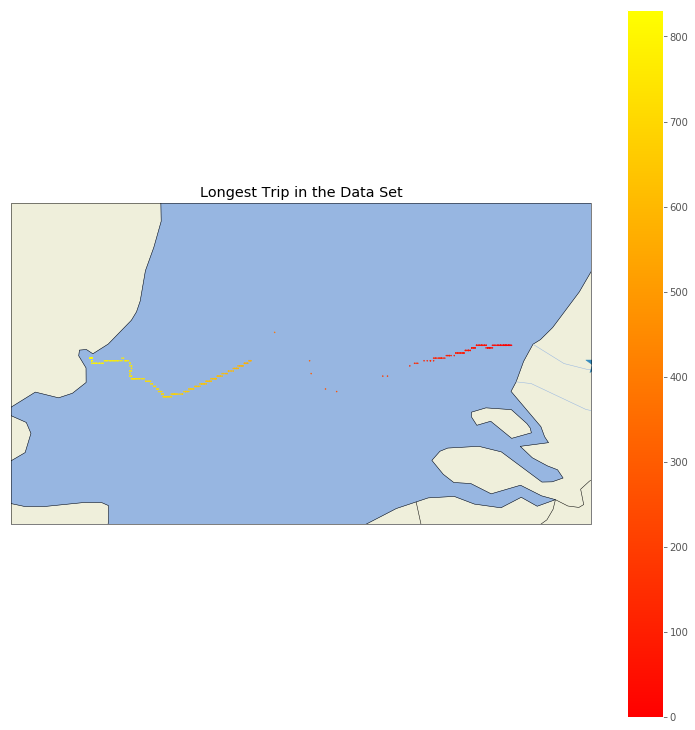

In [66]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

In [68]:
# Get and plot the shortest trip in the data set
shortest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].min()]
shortest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
101114,109490,51.92,1.38,2016-06-28 21:48:00,51.9,4.36,2016-06-29 02:27:00,2016-06-28 21:51:00,197.0,26.0,...,1.41,19.3,83.6,86.0,RTM-FXT-RTM,OZTS2,04:39:00,279.0,04:36:00,276.0
101119,109490,51.92,1.38,2016-06-28 21:48:00,51.9,4.36,2016-06-29 02:27:00,2016-06-28 21:58:00,197.0,26.0,...,1.47,20.7,80.2,83.0,RTM-FXT-RTM,OZTS2,04:39:00,279.0,04:29:00,269.0
101188,109490,51.92,1.38,2016-06-28 21:48:00,51.9,4.36,2016-06-29 02:27:00,2016-06-28 22:02:00,197.0,26.0,...,1.51,21.6,70.5,69.0,RTM-FXT-RTM,OZTS2,04:39:00,279.0,04:25:00,265.0
101191,109490,51.92,1.38,2016-06-28 21:48:00,51.9,4.36,2016-06-29 02:27:00,2016-06-28 22:09:00,197.0,26.0,...,1.57,23.3,53.5,54.0,RTM-FXT-RTM,OZTS2,04:39:00,279.0,04:18:00,258.0
101192,109490,51.92,1.38,2016-06-28 21:48:00,51.9,4.36,2016-06-29 02:27:00,2016-06-28 21:54:00,197.0,26.0,...,1.43,19.8,84.1,87.0,RTM-FXT-RTM,OZTS2,04:39:00,279.0,04:33:00,273.0


Text(0.5,1,u'Shortest Trip in the Data Set')

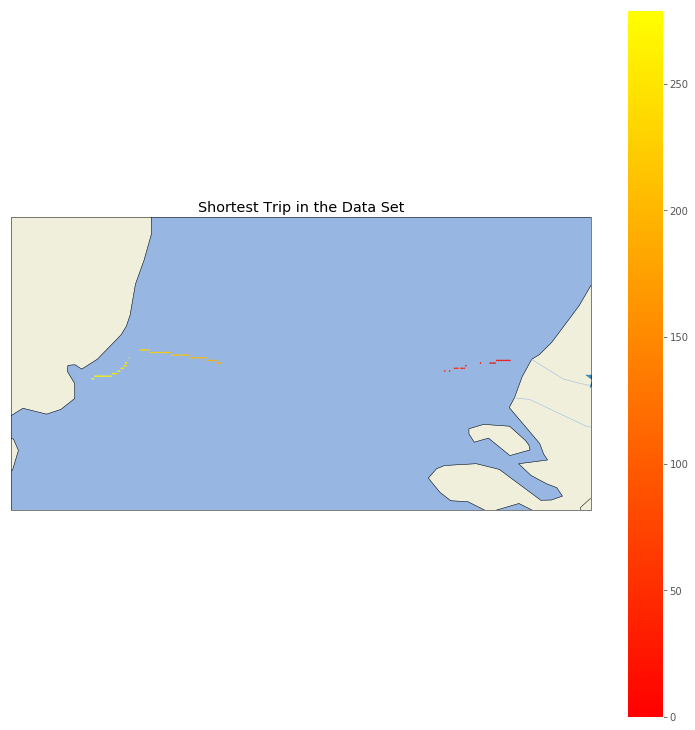

In [70]:
aismap.col_plot_to_map(size = (13, 13), longitude = shortest_trip['Longitude'], latitude = shortest_trip['Latitude'], col = shortest_trip['remainingMins'])
plt.title("Shortest Trip in the Data Set")

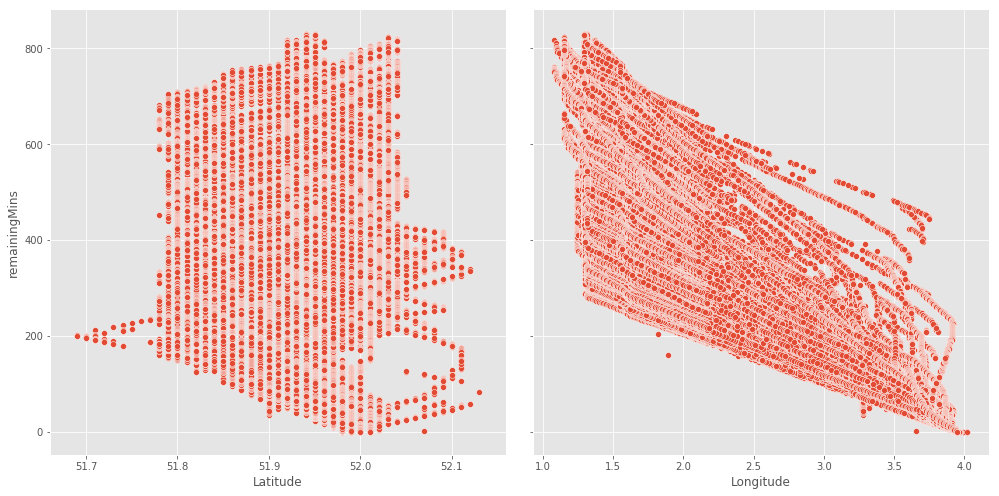

In [67]:
sns.pairplot(ais_shortmaj, x_vars = ['Latitude', 'Longitude'], y_vars = 'remainingMins', size = 7)

In [71]:
ais_shortmaj.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
0,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 15:37:00,2016-01-21 08:47:00,196.0,26.0,...,1.31,1.2,264.0,297.0,RTM-FXT-RTM,OVPB2,06:51:00,411.0,06:50:00,410.0
1,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 15:37:00,2016-01-21 08:48:00,196.0,26.0,...,1.31,2.3,285.0,293.0,RTM-FXT-RTM,OVPB2,06:51:00,411.0,06:49:00,409.0
2,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 15:37:00,2016-01-21 08:49:00,196.0,26.0,...,1.30,4.6,280.0,262.0,RTM-FXT-RTM,OVPB2,06:51:00,411.0,06:48:00,408.0
3,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 15:37:00,2016-01-21 08:50:00,196.0,26.0,...,1.30,3.7,251.0,218.0,RTM-FXT-RTM,OVPB2,06:51:00,411.0,06:47:00,407.0
4,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 15:37:00,2016-01-21 08:51:00,196.0,26.0,...,1.30,3.8,210.0,180.0,RTM-FXT-RTM,OVPB2,06:51:00,411.0,06:46:00,406.0


In [72]:
ais_shortmaj.columns

Index([u'TripID', u'StartLatitude', u'StartLongitude', u'StartTime',
       u'EndLatitude', u'EndLongitude', u'EndTime', u'time', u'Length',
       u'Breadth', u'Draught', u'Latitude', u'Longitude', u'SOG', u'COG',
       u'TH', u'Destination', u'Callsign', u'TravelTime', u'TravelTimeMins',
       u'remainingTT', u'remainingMins'],
      dtype='object')

In [73]:
ais_learners = ais_shortmaj[['TripID', 'time', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
                             'SOG', 'COG', 'TH', 'remainingMins']]
ais_learners = ais_learners.dropna()
ais_learners.head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,remainingMins
0,40903,2016-01-21 08:47:00,196.0,26.0,6.68,51.95,1.31,1.2,264.0,297.0,410.0
1,40903,2016-01-21 08:48:00,196.0,26.0,6.68,51.95,1.31,2.3,285.0,293.0,409.0
2,40903,2016-01-21 08:49:00,196.0,26.0,6.68,51.95,1.30,4.6,280.0,262.0,408.0
3,40903,2016-01-21 08:50:00,196.0,26.0,6.68,51.95,1.30,3.7,251.0,218.0,407.0
4,40903,2016-01-21 08:51:00,196.0,26.0,6.68,51.95,1.30,3.8,210.0,180.0,406.0


In [75]:
X = ais_learners[['Latitude', 'Longitude', 'SOG']]
y = ais_learners['remainingMins']

In [77]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = ais_learners['TripID']))

In [78]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [79]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin_params = dict(normalize = [True, False])
lin_grid = GridSearchCV(lin, lin_params, cv = cv_splits, scoring = 'neg_mean_absolute_error')
lin_grid.fit(X, y)

lin_grid.grid_scores_

/home/vhanke/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -42.54962, std: 2.48717, params: {'normalize': True},
 mean: -42.54962, std: 2.48717, params: {'normalize': False}]

In [80]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_params = dict(n_neighbors = range(1, 50), weights = ['uniform', 'distance'])
knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, scoring = 'neg_mean_absolute_error', n_iter = 10)
knn_rand.fit(X, y)

knn_rand.grid_scores_

/home/vhanke/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -32.70086, std: 2.44302, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: -30.37916, std: 2.45455, params: {'n_neighbors': 41, 'weights': 'uniform'},
 mean: -30.75737, std: 2.44271, params: {'n_neighbors': 13, 'weights': 'uniform'},
 mean: -34.74376, std: 2.47429, params: {'n_neighbors': 2, 'weights': 'distance'},
 mean: -31.16955, std: 2.45297, params: {'n_neighbors': 9, 'weights': 'uniform'},
 mean: -34.79127, std: 2.47225, params: {'n_neighbors': 2, 'weights': 'uniform'},
 mean: -30.50161, std: 2.43536, params: {'n_neighbors': 19, 'weights': 'uniform'},
 mean: -30.40012, std: 2.46247, params: {'n_neighbors': 46, 'weights': 'distance'},
 mean: -30.37617, std: 2.46449, params: {'n_neighbors': 39, 'weights': 'uniform'},
 mean: -30.37822, std: 2.47713, params: {'n_neighbors': 35, 'weights': 'uniform'}]

In [81]:
knn_best = KNeighborsRegressor(n_neighbors = 60, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(X_test)

In [82]:
knn_predicts

array([410.26666667, 393.16666667, 391.66666667, ...,   2.66666667,
         1.        ,   0.        ])

In [83]:
y_test.values

array([341., 340., 339., ...,   2.,   1.,   0.])

In [84]:
knn_predicts_diffs = knn_predicts - y_test

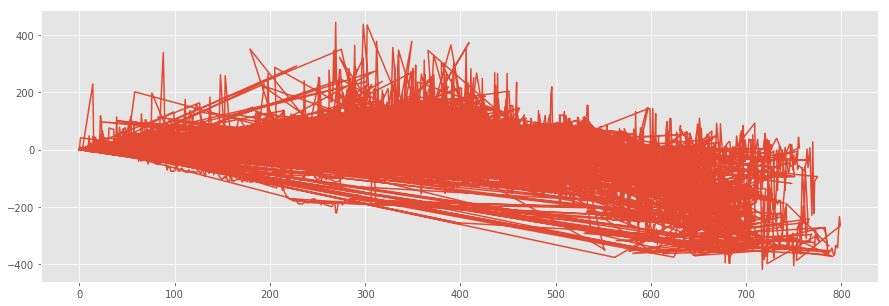

In [85]:
plt.figure(figsize = (15, 5))
plt.plot(y_test, knn_predicts_diffs)

In [86]:
from sklearn.ensemble import RandomForestRegressor

rfo = RandomForestRegressor()
rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, scoring = 'neg_mean_absolute_error', n_iter = 10)
rfo_rand.fit(X, y)

rfo_rand.grid_scores_

/home/vhanke/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -30.78500, std: 2.40394, params: {'n_estimators': 2, 'max_depth': 8},
 mean: -31.11138, std: 2.46919, params: {'n_estimators': 8, 'max_depth': 7},
 mean: -35.66246, std: 2.25187, params: {'n_estimators': 5, 'max_depth': 5},
 mean: -29.74193, std: 2.38219, params: {'n_estimators': 9, 'max_depth': 10},
 mean: -31.30765, std: 2.50385, params: {'n_estimators': 3, 'max_depth': 7},
 mean: -29.59954, std: 2.40213, params: {'n_estimators': 8, 'max_depth': 11},
 mean: -30.48079, std: 2.31944, params: {'n_estimators': 1, 'max_depth': 12},
 mean: -30.07187, std: 2.37834, params: {'n_estimators': 2, 'max_depth': 14},
 mean: -29.60199, std: 2.37464, params: {'n_estimators': 9, 'max_depth': 11},
 mean: -32.91719, std: 2.41767, params: {'n_estimators': 7, 'max_depth': 6}]